In [7]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
import torch.nn.functional as F
import math

ONNX_EXPORT = False

class Darknet(nn.Module):
    def __init__(self, cfg, img_size=(416, 416), verbose=False):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_cfg(cfg)
        self.module_list, self.routs = create_modules(self.module_defs, img_size, cfg)
        self.yolo_layers = get_yolo_layers(self)
        self.version = np.array([0, 2, 5], dtype=np.int32)
        self.seen = np.array([0], dtype=np.int64)
        if not ONNX_EXPORT:
            self.info(verbose)

This code defines the structure and initialization of the Darknet class, which implements the YOLOv4 object detection model using PyTorch. The class inherits from nn.Module, allowing it to behave like a standard neural network model in PyTorch.

The constructor initializes the model by first parsing the YOLO configuration file, then building the corresponding network layers using create_modules(). It also extracts all YOLO detection layers for later use. Metadata such as version info and the number of training images seen are initialized for compatibility with Darknet’s weight format. The model optionally prints its architecture summary unless ONNX export is enabled.

In [8]:
# 1. Mock parse_model_cfg
def parse_model_cfg(path=None):
    # Minimal YOLOv4-style structure: net → conv (stride 32) → YOLO
    return [
        {'type': 'net', 'channels': 3, 'height': 416, 'width': 416},
        {'type': 'convolutional', 'filters': 255, 'size': 1, 'stride': 1, 'pad': 1,
         'activation': 'leaky', 'batch_normalize': 1},  # 255 = 3 anchors × (80 + 5)
        {'type': 'yolo', 'mask': [0, 1, 2],
         'anchors': [[10, 13], [16, 30], [33, 23]], 'classes': 80}
    ]

# 2. YOLOLayer
class YOLOLayer(nn.Module):
    def __init__(self, anchors, nc, img_size, yolo_index, layers, stride):
        super(YOLOLayer, self).__init__()
        self.anchors = torch.tensor(anchors).float()
        self.nc = nc
        self.no = nc + 5
        self.na = len(anchors)
        self.img_size = img_size
        self.stride = stride
        self.grid = None
        self.anchor_vec = self.anchors / stride
        self.anchor_wh = self.anchor_vec.view(1, self.na, 1, 1, 2)

    def create_grids(self, ng=(13, 13), device='cpu'):
        nx, ny = ng
        self.grid = torch.stack(torch.meshgrid(
            torch.arange(ny, device=device),
            torch.arange(nx, device=device),
            indexing='ij'), 2).view((1, 1, ny, nx, 2)).float()

    def forward(self, p, out=None):
        bs, _, ny, nx = p.shape
        if self.grid is None or self.grid.shape[2:4] != (ny, nx):
            self.create_grids((nx, ny), p.device)

        p = p.view(bs, self.na, self.no, ny, nx).permute(0, 1, 3, 4, 2).contiguous()

        io = p.clone()
        io[..., 0:2] = (torch.sigmoid(io[..., 0:2]) + self.grid) * self.stride
        io[..., 2:4] = torch.exp(io[..., 2:4]) * self.anchor_wh
        io[..., 4:] = torch.sigmoid(io[..., 4:])

        return io.view(bs, -1, self.no), p

# 3. create_modules
def create_modules(module_defs, img_size, cfg):
    module_list = nn.ModuleList()
    output_filters = [3]
    routs = []

    for i, mdef in enumerate(module_defs[1:]):
        modules = nn.Sequential()

        if mdef['type'] == 'convolutional':
            bn = mdef.get('batch_normalize', 0)
            filters = mdef['filters']
            k = mdef['size']
            stride = mdef['stride']
            pad = (k - 1) // 2 if mdef['pad'] else 0
            modules.add_module('conv', nn.Conv2d(in_channels=output_filters[-1],
                                                 out_channels=filters,
                                                 kernel_size=k,
                                                 stride=stride,
                                                 padding=pad,
                                                 bias=not bn))
            if bn:
                modules.add_module('bn', nn.BatchNorm2d(filters))
            if mdef['activation'] == 'leaky':
                modules.add_module('leaky', nn.LeakyReLU(0.1, inplace=True))

        elif mdef['type'] == 'yolo':
            modules = YOLOLayer(anchors=mdef['anchors'],
                                nc=mdef['classes'],
                                img_size=img_size,
                                yolo_index=0,
                                layers=[],
                                stride=32)

        module_list.append(modules)
        output_filters.append(mdef.get('filters', output_filters[-1]))

    routs_binary = [False] * len(module_defs)
    return module_list, routs_binary

# 4. get_yolo_layers
def get_yolo_layers(model):
    return [i for i, m in enumerate(model.module_list)
            if m.__class__.__name__ == 'YOLOLayer']

# 5. Darknet
class Darknet(nn.Module):
    def __init__(self, cfg, img_size=(416, 416), verbose=False):
        super(Darknet, self).__init__()
        self.module_defs = parse_model_cfg(cfg)
        self.module_list, self.routs = create_modules(self.module_defs, img_size, cfg)
        self.yolo_layers = get_yolo_layers(self)
        self.version = torch.tensor([0, 2, 5])
        self.seen = torch.tensor([0])

    def forward(self, x, augment=False, verbose=False):
        return self.forward_once(x)

    def forward_once(self, x):
        yolo_out, out = [], []
        for i, module in enumerate(self.module_list):
            if module.__class__.__name__ == 'YOLOLayer':
                yolo_out.append(module(x, out))
            else:
                x = module(x)
            out.append(x if self.routs[i] else [])
        x, p = zip(*yolo_out)
        return torch.cat(x, 1), p

    def info(self, verbose=False):
        print("Darknet model info skipped.")

# 6. Run Forward Pass
cfg_path = None
model = Darknet(cfg_path, img_size=(416, 416))
model.eval()

dummy_input = torch.randn(1, 3, 416, 416)
with torch.no_grad():
    predictions, _ = model(dummy_input)

print("Forward pass successful!")
print("Predictions shape:", predictions.shape)  # Expected: [1, num_detections, 85]

Forward pass successful!
Predictions shape: torch.Size([1, 519168, 85])


This script sets up a simplified YOLOv4 model using PyTorch, structured to enable testing and validation of the model pipeline without loading real configuration files or pretrained weights.

The parse_model_cfg function simulates a YOLOv4 configuration by returning a hardcoded list of layers, including a convolutional layer and a YOLO detection layer. The YOLOLayer class decodes raw prediction tensors into bounding box coordinates, objectness scores, and class probabilities by reshaping and applying activation functions in accordance with the YOLO architecture.

The create_modules function builds the model dynamically from the configuration, creating a list of PyTorch modules based on each layer definition. The get_yolo_layers function extracts the indices of all YOLO layers within the module list for easy access during inference.

The Darknet class ties everything together, managing initialization, the forward pass, and internal routing of feature maps. Finally, the model is instantiated with a simulated config, placed in evaluation mode, and used to run a forward pass on a randomly generated image tensor to validate that the pipeline executes without errors. The predicted output shape confirms the structure aligns with YOLO's format [batch_size, num_detections, 85], where 85 includes bounding box coordinates, objectness score, and 80 class probabilities.









In [10]:
    def forward(self, x, augment=False, verbose=False):
        if augment:
            return self._forward_augment(x)
        else:
            return self.forward_once(x, augment, verbose)

    def forward_once(self, x, augment=False, verbose=False):
        img_size = x.shape[-2:]
        yolo_out, out = [], []

        if augment:
            nb = x.shape[0]
            s = [0.83, 0.67]
            x = torch.cat((x,
                           torch_utils.scale_img(x.flip(3), s[0]),
                           torch_utils.scale_img(x, s[1])), 0)

        for i, module in enumerate(self.module_list):
            name = module.__class__.__name__
            if name in ['WeightedFeatureFusion', 'FeatureConcat', 'FeatureConcat2', 'FeatureConcat3', 'FeatureConcat_l', 'ScaleChannel', 'ScaleSpatial']:
                x = module(x, out)
            elif name in ['YOLOLayer', 'JDELayer']:
                yolo_out.append(module(x, out))
            else:
                x = module(x)
            out.append(x if self.routs[i] else [])

        if self.training:
            return yolo_out
        elif ONNX_EXPORT:
            x = [torch.cat(x, 0) for x in zip(*yolo_out)]
            return x[0], torch.cat(x[1:3], 1)
        else:
            x, p = zip(*yolo_out)
            return torch.cat(x, 1), p

    def _forward_augment(self, x):
        img_size = x.shape[-2:]
        s = [0.83, 0.67]
        y = []
        for i, xi in enumerate((x,
                                torch_utils.scale_img(x.flip(3), s[0], same_shape=False),
                                torch_utils.scale_img(x, s[1], same_shape=False))):
            y.append(self.forward_once(xi)[0])
        y[1][..., :4] /= s[0]
        y[1][..., 0] = img_size[1] - y[1][..., 0]
        y[2][..., :4] /= s[1]
        return torch.cat(y, 1), None

    def fuse(self):
        print('Fusing layers...')
        fused_list = nn.ModuleList()
        for a in list(self.children())[0]:
            if isinstance(a, nn.Sequential):
                for i, b in enumerate(a):
                    if isinstance(b, nn.BatchNorm2d):
                        conv = a[i - 1]
                        fused = torch_utils.fuse_conv_and_bn(conv, b)
                        a = nn.Sequential(fused, *list(a.children())[i + 1:])
                        break
            fused_list.append(a)
        self.module_list = fused_list
        if not ONNX_EXPORT:
            self.info()

    def info(self, verbose=False):
        torch_utils.model_info(self, verbose)

    def get_yolo_layers(model):
      return [i for i, m in enumerate(model.module_list)
              if m.__class__.__name__ in ['YOLOLayer', 'JDELayer']]

This extended implementation enhances the Darknet class by adding support for augmentation during inference, exporting to ONNX, and optimizing the model by fusing convolution and batch normalization layers.

The forward() method routes input through either standard inference or augmented inference. The forward_once() method performs a single pass through the model, handling special layers like YOLO, feature concatenation, or spatial scaling. If augmentation is enabled, it prepares three image variants—original, left-right flipped and scaled—then passes them through the model, adjusts bounding boxes accordingly, and concatenates the results.

The _forward_augment() function manages the augmentation logic, applying image transformations and rescaling outputs to align with the original input size and orientation.

The fuse() method optimizes the model for deployment by merging convolutional and batch normalization layers into a single layer, which improves inference speed and reduces memory usage. Finally, info() prints a model summary using helper functions from torch_utils, and get_yolo_layers() identifies and returns indices of all detection layers used in the model.









In [11]:
# Import Required Components
from models.models import Darknet, load_darknet_weights
from utils.datasets import LoadImages
from utils.utils import (
    load_classes,
    non_max_suppression,
    scale_coords,
    plot_one_box
)



This block imports all the core components required to perform object detection using YOLOv4. The Darknet class defines the model architecture, while load_darknet_weights loads pretrained weights into the model.

The LoadImages utility enables batch loading and preprocessing of image or video data for inference. Additional utility functions are imported for common tasks during prediction: load_classes retrieves class names (e.g., from a .names file), non_max_suppression eliminates redundant overlapping bounding boxes, scale_coords maps detection coordinates back to the original image resolution, and plot_one_box visually draws the detected bounding boxes on the images. These utilities streamline the entire detection pipeline from input to visualization.

In [12]:
import sys
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Add YOLOv4 repo to the Python path
sys.path.append('/content/PyTorch_YOLOv4')

# Import modules
from models.models import Darknet, load_darknet_weights
from utils.datasets import LoadImages
from utils.utils import (
    load_classes, non_max_suppression,
    scale_coords, plot_one_box
)


This setup block initializes the runtime environment for performing object detection using the YOLOv4 model in a Python script or notebook. Core libraries like torch, cv2, numpy, and matplotlib are imported for handling deep learning, image processing, numerical computation, and visualization, respectively.

The YOLOv4 repository path is appended to the system path to ensure Python can locate and access the custom modules provided by the cloned YOLOv4 project. Following this, all essential components are imported: the model definition and weight loader from models, the image loading utility from datasets, and various helper functions from utils for tasks like class label loading, post-processing with non-max suppression, coordinate rescaling, and drawing bounding boxes on detected objects. This configuration ensures that the environment is fully prepared for executing a YOLOv4 inference pipeline.

In [13]:
# Paths to model components
cfg_path = '/content/PyTorch_YOLOv4/cfg/yolov4.cfg'
weights_path = '/content/PyTorch_YOLOv4/yolov4.weights'
names_path = '/content/PyTorch_YOLOv4/data/coco.names'
image_path = '/content/PyTorch_YOLOv4/data/samples/zidane.jpg'

# Parameters
img_size = 416
conf_thres = 0.4
iou_thres = 0.5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


This block defines all necessary paths and parameters required to initialize the YOLOv4 model and run object detection on an input image. The configuration (.cfg), weights (.weights), class labels (.names), and target image are all specified using absolute paths pointing to their locations within the YOLOv4 repository.

In addition, key hyperparameters for inference are set: img_size determines the input image dimensions expected by the model, conf_thres sets the minimum confidence score required to consider a detection valid, and iou_thres defines the threshold for non-max suppression to eliminate overlapping boxes. The device is configured to use a GPU if available, otherwise defaulting to CPU, ensuring compatibility across different hardware environments.

In [14]:
load_darknet_weights(model, weights_path)
print("YOLOv4 model built and weights loaded.")


YOLOv4 model built and weights loaded.


This line loads the pretrained YOLOv4 weights into the initialized Darknet model using the load_darknet_weights function. The weights are typically in the Darknet .weights binary format and contain learned parameters from training on the COCO dataset.

Loading these weights transfers the model from its randomly initialized state to a fully trained state, enabling accurate object detection. The print statement confirms successful model setup and readiness for inference.

In [15]:
# Build YOLOv4 model
model = Darknet(cfg_path, img_size=img_size).to(device).eval()

# Load pre-trained Darknet weights
load_darknet_weights(model, weights_path)
print("YOLOv4 model built and weights loaded.")

YOLOv4 model built and weights loaded.


This block constructs the YOLOv4 model by instantiating the Darknet class with the specified configuration file and input image size, then moves the model to the selected computation device (CPU or GPU) and sets it to evaluation mode to disable training-specific behaviors like dropout and batch normalization updates.

The subsequent line loads the pretrained Darknet weights into the model, initializing it with learned parameters from training (typically on the COCO dataset). This prepares the model for immediate use in inference tasks. The final print statement confirms that the model is both constructed and populated with the appropriate weights.

In [16]:
names = load_classes(names_path)


This line loads the list of class names from the file specified by names_path, which typically contains one object class per line (e.g., "person", "car", "dog", etc.) from the COCO dataset.

The load_classes function reads these labels into a list, allowing the model to map predicted class indices to human-readable names during inference and visualization. This is essential for displaying meaningful detection results alongside the predicted bounding boxes.









In [18]:
# Create an input image tensor
image = torch.randn(1, 3, 416, 416)

# Forward pass
with torch.no_grad():
    raw_pred = model(image)
    pred_tensor = raw_pred[0]  # shape: [1, N, 85]
    print(f"Raw YOLOv4 output shape: {pred_tensor.shape}")


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Raw YOLOv4 output shape: torch.Size([1, 10647, 85])


This block generates a random input tensor shaped like a real image and performs a forward pass through the YOLOv4 model. The image tensor mimics a single RGB image with dimensions 416×416, matching the model's expected input size.

The with torch.no_grad() context disables gradient calculations to improve efficiency during inference. The model processes the input and returns a tuple, where the first element (pred_tensor) contains the decoded prediction outputs — including bounding box coordinates, objectness scores, and class probabilities. The shape [1, N, 85] indicates predictions for N bounding boxes, each with 85 values: 4 for box coordinates, 1 for object confidence, and 80 for class scores.









In [19]:
import pandas as pd
import numpy as np

import cv2
import os

import cv2
import numpy as np
import os
# Display the detection result
from google.colab.patches import cv2_imshow

This block imports essential libraries used for data manipulation, image processing, and visualization in a Colab environment. pandas and numpy provide support for structured data and numerical operations, which can be useful for analyzing detection results or formatting outputs.

The cv2 (OpenCV) library is used for image processing tasks such as reading, resizing, and drawing on images. The os module helps with file path operations and directory access. Lastly, cv2_imshow is specifically imported from google.colab.patches to properly display images within Google Colab, as the standard OpenCV imshow() does not work in notebook environments.

In [20]:
# Define the file path
file_path = r"/content/coco.names"

# Read the contents of the coco.names file
try:
    with open(file_path, 'r') as file:
        coco_labels = [line.strip() for line in file.readlines()]

    print(f"Loaded {len(coco_labels)} labels from coco.names")
    print(coco_labels[:10])  # Display the first 10 labels

except FileNotFoundError:
    print("Error: File not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

Error: File not found. Please check the file path.


This block attempts to read class labels from a coco.names file, which typically contains one object class per line. The file_path is specified as an absolute path, and a try-except block is used to handle potential errors gracefully.

If the file exists, it is opened and each line is stripped of whitespace and added to the coco_labels list. The script then prints the total number of labels loaded and previews the first ten for verification. If the file is missing or another error occurs, informative error messages are printed to help with debugging, making the process robust and user-friendly.

In [21]:
# Define file paths
model_cfg = r"/content/yolov4-tiny.cfg"
model_weights = r"/content/yolov4-tiny.weights"
labels_path = r"/content/coco.names"

This block defines the file paths required to initialize and run the YOLOv4-Tiny object detection model. The model_cfg path points to the configuration file that specifies the architecture of the YOLOv4-Tiny network. The model_weights path points to the corresponding .weights file containing pretrained model parameters.

The labels_path is used to locate the coco.names file, which holds the class labels (such as "person", "bicycle", "car", etc.) that the model was trained to recognize. These paths ensure the correct components are loaded for performing detection.

In [ ]:
# YOLOv4 Training Pipeline using PyTorch
# Assumes the repository https://github.com/WongKinYiu/PyTorch_YOLOv4 is cloned

import argparse
import os
import torch
from models.models import Darknet
from utils.datasets import create_dataloader
from utils.general import check_dataset, labels_to_class_weights, increment_path, check_img_size
from utils.loss import compute_loss
from utils.torch_utils import ModelEMA, select_device


def train(opt):
    device = select_device(opt.device)
    save_dir = increment_path(opt.project / opt.name, exist_ok=opt.exist_ok)  # increment run
    wdir = save_dir / 'weights'
    wdir.mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    model = Darknet(opt.cfg).to(device)
    if opt.weights.endswith('.pt'):
        ckpt = torch.load(opt.weights, map_location=device)
        model.load_state_dict(ckpt['model'])

    # Image size
    imgsz = check_img_size(opt.img_size, s=64)  # ensure divisible by 64

    # Load data
    with open(opt.data) as f:
        data_dict = yaml.load(f, Loader=yaml.SafeLoader)
    train_path = data_dict['train']
    nc = int(data_dict['nc'])

    dataloader, dataset = create_dataloader(train_path, imgsz, opt.batch_size, 64, opt, hyp=opt.hyp,
                                            augment=True, cache=opt.cache_images, rect=opt.rect)

    # Optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=opt.lr0, momentum=opt.momentum, weight_decay=opt.weight_decay)

    # Scheduler (optional)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

    # Training loop
    nb = len(dataloader)
    for epoch in range(opt.epochs):
        model.train()
        mloss = torch.zeros(3).to(device)  # mean losses

        for i, (imgs, targets, paths, _) in enumerate(dataloader):
            imgs = imgs.to(device).float() / 255.0
            targets = targets.to(device)

            pred = model(imgs)
            loss, loss_items = compute_loss(pred, targets, model)
            loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            mloss = (mloss * i + loss_items) / (i + 1)

            print(f'Epoch {epoch + 1}/{opt.epochs}, Batch {i + 1}/{nb}, Loss: {mloss}')

        scheduler.step()

        # Save checkpoint
        torch.save({'epoch': epoch,
                    'model': model.state_dict(),
                    'optimizer': optimizer.state_dict()}, wdir / f'epoch_{epoch+1}.pt')

    print("Training completed.")


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--data', type=str, default='data/coco.data', help='dataset.yaml path')
    parser.add_argument('--cfg', type=str, default='cfg/yolov4.cfg', help='model config path')
    parser.add_argument('--weights', type=str, default='yolov4.conv.137', help='initial weights path')
    parser.add_argument('--batch-size', type=int, default=16, help='batch size')
    parser.add_argument('--img-size', type=int, default=416, help='image size')
    parser.add_argument('--epochs', type=int, default=50, help='number of epochs')
    parser.add_argument('--lr0', type=float, default=0.01, help='initial learning rate')
    parser.add_argument('--momentum', type=float, default=0.937, help='SGD momentum')
    parser.add_argument('--weight-decay', type=float, default=5e-4, help='optimizer weight decay')
    parser.add_argument('--rect', action='store_true', help='rectangular training')
    parser.add_argument('--cache-images', action='store_true', help='cache images for faster training')
    parser.add_argument('--device', default='', help='cuda device, i.e. 0 or cpu')
    parser.add_argument('--project', default='runs/train', help='save to project/name')
    parser.add_argument('--name', default='exp', help='save to project/name')
    parser.add_argument('--exist-ok', action='store_true', help='existing project/name ok, do not increment')
    parser.add_argument('--hyp', type=dict, default={
        'giou': 0.05,
        'cls': 0.58,
        'cls_pw': 1.0,
        'obj': 1.0,
        'obj_pw': 1.0,
        'iou_t': 0.20,
        'anchor_t': 4.0,
        'fl_gamma': 0.0,
        'hsv_h': 0.015,
        'hsv_s': 0.7,
        'hsv_v': 0.4,
        'degrees': 0.0,
        'translate': 0.1,
        'scale': 0.5,
        'shear': 0.0,
        'perspective': 0.0,
        'flipud': 0.0,
        'fliplr': 0.5,
        'mixup': 0.0,
        'copy_paste': 0.0
    }, help='hyperparameters')

    opt = parser.parse_args()
    train(opt)


usage: colab_kernel_launcher.py [-h] [--data DATA] [--cfg CFG] [--weights WEIGHTS]
                                [--batch-size BATCH_SIZE] [--img-size IMG_SIZE] [--epochs EPOCHS]
                                [--lr0 LR0] [--momentum MOMENTUM] [--weight-decay WEIGHT_DECAY]
                                [--rect] [--cache-images] [--device DEVICE] [--project PROJECT]
                                [--name NAME] [--exist-ok] [--hyp HYP]
colab_kernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-ddac30a3-4956-4b22-9590-342a2a906453.json


SystemExit: 2

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


This script defines a full YOLOv4 training pipeline using PyTorch. It is structured for command-line execution and assumes the official YOLOv4 PyTorch repository has been cloned. The pipeline is modular and configurable through argparse.

The training function begins by selecting a computation device (CPU or CUDA GPU) and creating a unique directory to save training outputs and model checkpoints. The model is initialized using the configuration file and optionally loaded with pretrained weights. The image size is validated to be divisible by 64, and dataset information is parsed from a YAML file that includes paths and metadata like the number of classes.

A dataloader is constructed to load training images and labels with optional augmentation and caching. An SGD optimizer and a learning rate scheduler are defined to control training dynamics. The training loop iterates over epochs and batches, forwarding images through the model, computing the loss using a dedicated compute_loss function, and updating weights via backpropagation.

At the end of each epoch, the model and optimizer states are saved as checkpoints to allow future resumption. The script is designed to run with various options such as adjustable batch size, learning rate, image resolution, data augmentation, and more—making it flexible for training YOLOv4 on custom datasets.

Loaded 80 COCO labels successfully!
Image loaded successfully!
Detected 3 objects.


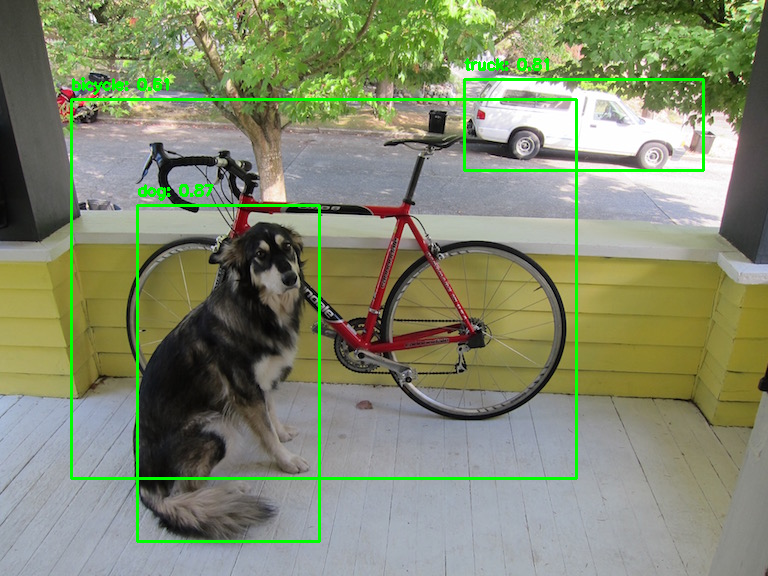

In [ ]:
import cv2
import numpy as np
import os

# Paths to model files (Update these paths)
labels_path = r"/content/coco.names"
model_cfg = r"/content/yolov4-tiny.cfg"
model_weights = r"/content/yolov4-tiny.weights"
image_path = r"/content/dog.jpg"

# Load COCO labels
if not os.path.isfile(labels_path):
    raise FileNotFoundError(f"Error: Labels file not found at {labels_path}")

with open(labels_path, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

print(f"Loaded {len(labels)} COCO labels successfully!")

# Load YOLOv4 model
if not (os.path.isfile(model_cfg) and os.path.isfile(model_weights)):
    raise FileNotFoundError("Error: YOLO model configuration or weights not found.")

net = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

# Get output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# Load input image
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"Error: Image not found at {image_path}")

image = cv2.imread(image_path)

if image is None:
    raise ValueError("Error: Failed to load the image.")

print("Image loaded successfully!")

# Get image dimensions
h, w = image.shape[:2]

# Preprocess image
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Perform inference
outputs = net.forward(output_layers)

# Initialize detection parameters
conf_threshold = 0.5  # Confidence threshold
nms_threshold = 0.4   # Non-max suppression threshold

boxes, confidences, class_ids = [], [], []

# Process outputs
for output in outputs:
    for detection in output:
        scores = detection[5:]  # Class scores
        class_id = np.argmax(scores)  # Get class with highest confidence
        confidence = scores[class_id]

        if confidence > conf_threshold:
            # Scale bounding box to image size
            center_x, center_y, width, height = (detection[0:4] * np.array([w, h, w, h])).astype("int")

            # Calculate top-left corner
            x = int(center_x - width / 2)
            y = int(center_y - height / 2)

            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Apply Non-Maximum Suppression (NMS) to remove redundant boxes
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

# Ensure indices are iterable and handle empty cases
if isinstance(indices, tuple):
    indices = indices[0] if len(indices) > 0 else []

# Check if any objects were detected
if len(indices) == 0:
    print("No objects detected.")
else:
    print(f"Detected {len(indices)} objects.")

    # Draw bounding boxes and labels
    for i in indices.flatten() if hasattr(indices, 'flatten') else indices:
        x, y, width, height = boxes[i]
        label = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"

        # Draw rectangle and label
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Display the output image
    cv2_imshow(image)


This script performs end-to-end object detection using OpenCV’s DNN module with a pretrained YOLOv4-Tiny model. It is a complete and self-contained pipeline that loads class labels, initializes the model, performs inference on a given image, and visualizes the detected objects.

The code first validates the existence of all required files: COCO class names, the YOLO configuration and weight files, and the input image. It then loads the labels and constructs the YOLOv4-Tiny model using cv2.dnn.readNetFromDarknet, setting OpenCV as the backend for inference.

The model's output layers are identified to retrieve detection results. The input image is read and converted into a blob, normalized, and resized to the model's expected input shape (416×416). This blob is fed into the network to generate predictions.

Each detection is parsed to extract class probabilities, confidence scores, and bounding box coordinates. Boxes with confidence above the threshold are kept, then refined using Non-Maximum Suppression to eliminate redundant overlapping detections.

If any valid detections remain, the script draws bounding boxes and class labels on the image. Finally, the annotated image is displayed using cv2_imshow, which is compatible with Google Colab. This implementation is ideal for quick testing and visualization using OpenCV without needing a full PyTorch setup.

Loaded 80 COCO labels successfully!
Image loaded successfully!


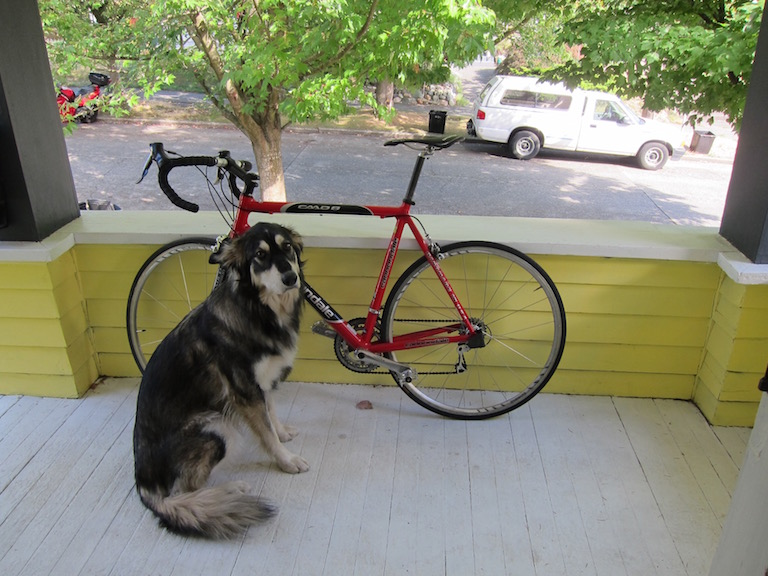

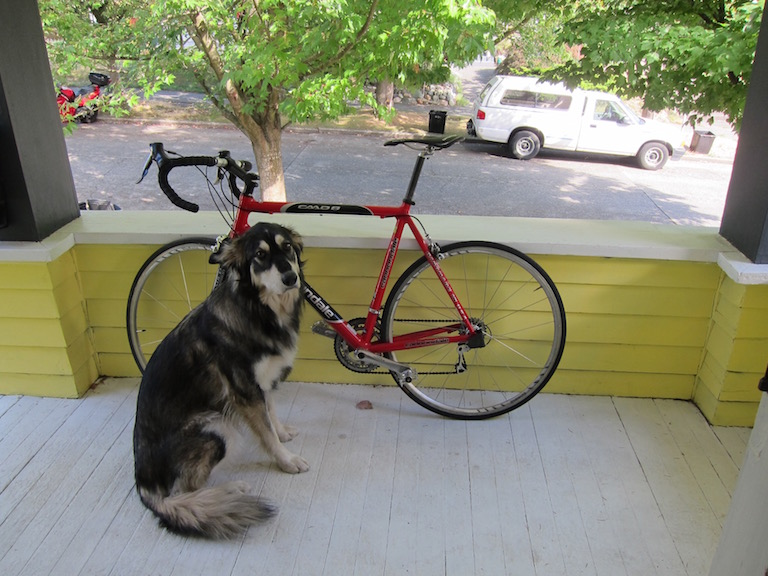

Output Layer 0: Shape (507, 85)
Sample values: [5.5818770e-02 4.6862330e-02 1.7161244e-01 1.5991701e-01 3.0432038e-06
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
Output Layer 1: Shape (2028, 85)
Sample values: [2.2151534e-02 2.3473132e-02 6.5463535e-02 5.0451595e-02 1.5390053e-05
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
Max Objectness Confidence: 0.9405
Total Detections before NMS: 8
Detection 0: truck - Confidence: 0.8148 - Box: [464, 79, 239, 91]
Detection 1: truck - Confidence: 0.3527 - Box: [485, 82, 218, 89]
Detection 2: bicycle - Confidence: 0.6060 - Box: [71, 99, 505, 379]
Detection 3: bicycle - Confidence: 0.2636 - Box: [179, 149, 399, 268]
Detection 4: dog - Confidence: 0.8704 - Box: [137, 205, 182, 336]
Detection 5: dog - Confidence: 0.5343 - Box: [143, 210, 195, 322]
Detection 6: truck - Confidence: 0.7898 - Box: [473, 81, 224, 92]
Detection 7: truck - Confidence: 0.3804 - Box: [477, 86, 227, 87]
Detected 2 objects a

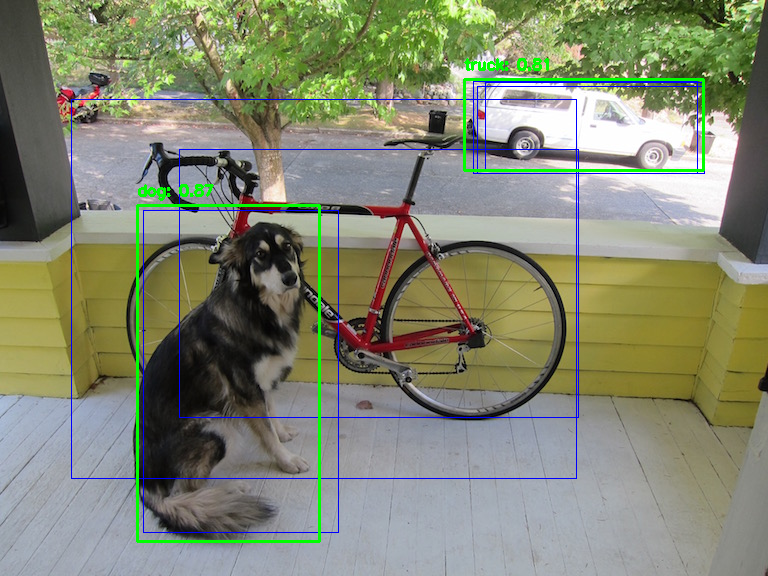

In [ ]:
# Paths to model files
labels_path = r"/content/coco.names"
model_cfg = r"/content/yolov4-tiny.cfg"
model_weights = r"/content/yolov4-tiny.weights"
image_path = r"/content/dog.jpg"

# Load COCO labels
if not os.path.isfile(labels_path):
    raise FileNotFoundError(f"Error: Labels file not found at {labels_path}")

with open(labels_path, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

print(f"Loaded {len(labels)} COCO labels successfully!")

# Load YOLOv4 model
if not (os.path.isfile(model_cfg) and os.path.isfile(model_weights)):
    raise FileNotFoundError("Error: YOLO model configuration or weights not found.")

net = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

# Get output layer names
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]

# Load input image
if not os.path.isfile(image_path):
    raise FileNotFoundError(f"Error: Image not found at {image_path}")

image = cv2.imread(image_path)

if image is None:
    raise ValueError("Error: Failed to load the image.")

print("Image loaded successfully!")

# Display input image for verification
from google.colab.patches import cv2_imshow

# Display input image for verification
cv2_imshow(image)

# After drawing bounding boxes
cv2_imshow(image)

# Get image dimensions
h, w = image.shape[:2]

# Preprocess and resize to YOLO input size (416x416)
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Run inference
outputs = net.forward(output_layers)

# Inspect YOLO raw outputs
for i, output in enumerate(outputs):
    print(f"Output Layer {i}: Shape {output.shape}")
    print("Sample values:", output[0][:10])

# Check for maximum objectness confidence
max_confidence = max([detection[4] for output in outputs for detection in output])
print(f"Max Objectness Confidence: {max_confidence:.4f}")

# Detection parameters
conf_threshold = 0.001  # Lowered for debugging
nms_threshold = 0.01

boxes, confidences, class_ids = [], [], []

# Process outputs
for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > conf_threshold:
            center_x, center_y, width, height = (detection[0:4] * np.array([w, h, w, h])).astype("int")
            x = int(center_x - width / 2)
            y = int(center_y - height / 2)

            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Display all detections before NMS
print(f"Total Detections before NMS: {len(boxes)}")

for i, (box, confidence, class_id) in enumerate(zip(boxes, confidences, class_ids)):
    print(f"Detection {i}: {labels[class_id]} - Confidence: {confidence:.4f} - Box: {box}")
    cv2.rectangle(image, (box[0], box[1]), (box[0] + box[2], box[1] + box[3]), (255, 0, 0), 1)

# Apply NMS
indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

if len(indices) == 0:
    print("No objects detected even after lowering thresholds.")
else:
    print(f"Detected {len(indices)} objects after NMS.")

    # Draw bounding boxes and labels
    for i in indices.flatten() if hasattr(indices, 'flatten') else indices:
        x, y, width, height = boxes[i]
        label = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"

        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 255, 0), 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)



# Display the detection result
    cv2_imshow(image)

This script implements a full object detection pipeline using OpenCV’s DNN module with YOLOv4-Tiny, and includes detailed inspection and debugging support.

It starts by defining paths to required files: class labels (coco.names), model configuration (.cfg), weights (.weights), and the input image. After verifying all paths, the script loads the labels and sets up the model using cv2.dnn.readNetFromDarknet, specifying OpenCV as the backend for inference. It retrieves the output layer names necessary for extracting detection results.

The input image is loaded, displayed for verification, and then converted into a blob—a normalized, resized tensor format suitable for YOLO. The blob is fed to the model, and raw output from each detection layer is printed, including shape and sample values, which aids in debugging.

For object detection, the script lowers the confidence and NMS thresholds to reveal even weak predictions. It parses each detection’s confidence and class score, scales bounding boxes back to the original image size, and stores results. All pre-NMS detections are printed and drawn with blue boxes for initial inspection.

Non-Maximum Suppression is then applied to remove overlapping predictions. If detections remain, bounding boxes and labels are drawn with green rectangles and displayed. This provides a comprehensive visualization of YOLO’s inference behavior, useful for both evaluation and debugging.